In [ ]:
import os
import json
import re

# Define the folder path containing the JSON files
folder_path = "data_symbolic_regression/train"

# Function to tokenize a formula
def tokenize_formula(formula):
    # Define a regex pattern to extract tokens (identifiers, operators, parentheses, etc.)
    token_pattern = r"[a-zA-Z_][a-zA-Z0-9_]*|[()+\-*/]|\d+\.?\d*"
    tokens = re.findall(token_pattern, formula)
    return tokens

# Iterate over all files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith(".json") and not file_name.startswith('properties'):
        file_path = os.path.join(folder_path, file_name)
        
        # Open and read the JSON file
        with open(file_path, "r") as file:
            data = json.load(file)
            
            # Extract the human-readable formula
            formula_human_readable = data.get("formula_human_readable", "")
            
            if formula_human_readable:
                # Tokenize the formula
                tokens = tokenize_formula(formula_human_readable)
                
                # Print or store the tokens for further analysis
                print(f"File: {file_name}")
                print(f"Formula: {formula_human_readable}")
                print(f"Tokens: {tokens}\n")

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np

class TextDiffusionModel:
    def __init__(self, vocab_size, seq_len, device="cpu"):
        """
        Initialize the text diffusion model.

        Parameters:
        - vocab_size: Size of the vocabulary (number of unique tokens).
        - seq_len: Length of the token sequence.
        - device: Device to use ("cpu" or "cuda").
        """
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.device = device
        self.noise_schedule = torch.linspace(0.01, 0.1, steps=1000).to(device)  # Noise variance per timestep

    def add_noise(self, tokens, t):
        """
        Add noise to a sequence of tokens based on timestep t.

        Parameters:
        - tokens: A tensor of token indices with shape (batch_size, seq_len).
        - t: A tensor of timesteps with shape (batch_size,).

        Returns:
        - noisy_tokens: The tokens with added noise.
        - noise: The noise added to the tokens.
        """
        noise_std = self.noise_schedule[t].view(-1, 1, 1)  # Shape: (batch_size, 1, 1)

        # Convert tokens to one-hot vectors
        one_hot = F.one_hot(tokens, num_classes=self.vocab_size).float()
        
        # Add Gaussian noise to the one-hot vectors
        noise = torch.randn_like(one_hot) * noise_std
        noisy_one_hot = one_hot + noise

        # Compute softmax to normalize the noisy one-hot vectors
        noisy_tokens = F.softmax(noisy_one_hot, dim=-1)
        return noisy_tokens, noise

    def sample_from_noisy_tokens(self, noisy_tokens):
        """
        Sample discrete tokens from the noisy token distribution.

        Parameters:
        - noisy_tokens: A tensor of noisy token distributions with shape (batch_size, seq_len, vocab_size).

        Returns:
        - sampled_tokens: A tensor of sampled token indices with shape (batch_size, seq_len).
        """
        sampled_tokens = torch.argmax(noisy_tokens, dim=-1)
        return sampled_tokens

# Example usage
if __name__ == "__main__":
    # Hyperparameters
    vocab_size = 100  # Example vocabulary size
    seq_len = 10  # Example sequence length
    batch_size = 4  # Example batch size
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Initialize the model
    model = TextDiffusionModel(vocab_size, seq_len, device=device)

    # Generate a batch of random tokens
    tokens = torch.randint(0, vocab_size, (batch_size, seq_len), device=device)

    # Choose random timesteps for each batch
    t = torch.randint(0, 1000, (batch_size,), device=device)

    # Add noise to the tokens
    noisy_tokens, noise = model.add_noise(tokens, t)

    # Sample from noisy tokens
    sampled_tokens = model.sample_from_noisy_tokens(noisy_tokens)

    # Print results
    print("Original Tokens:", tokens)
    print("Noisy Tokens (probabilities):", noisy_tokens)
    print("Sampled Tokens:", sampled_tokens)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import json
import re
from dataclasses import dataclass

# Define a function to tokenize a formula
def tokenize_formula(formula):
    token_pattern = r"[a-zA-Z_][a-zA-Z0-9_]*|[()+\-*/]|\d+\.?\d*"
    tokens = re.findall(token_pattern, formula)
    return tokens

@dataclass
class tNetConfig:
    num_vars: int
    embedding_size: int

class tNet(nn.Module):
    def __init__(self, config: tNetConfig):
        super(tNet, self).__init__()

        self.config = config
        self.num_vars = config.num_vars
        self.n_embd = config.embedding_size

        self.activation_func = F.relu

        self.conv1 = nn.Conv1d(self.num_vars + 1, self.n_embd, 1)
        self.conv2 = nn.Conv1d(self.n_embd, 2 * self.n_embd, 1)
        self.conv3 = nn.Conv1d(2 * self.n_embd, 4 * self.n_embd, 1)

        self.fc1 = nn.Linear(4 * self.n_embd, 2 * self.n_embd)
        self.fc2 = nn.Linear(2 * self.n_embd, self.n_embd)

        self.input_batch_norm = nn.GroupNorm(1, self.num_vars + 1)

        self.bn1 = nn.GroupNorm(1, self.n_embd)
        self.bn2 = nn.GroupNorm(1, 2 * self.n_embd)
        self.bn3 = nn.GroupNorm(1, 4 * self.n_embd)
        self.bn4 = nn.GroupNorm(1, 2 * self.n_embd)
        self.bn5 = nn.GroupNorm(1, self.n_embd)

    def forward(self, x):
        """
        :param x: [batch, #features + 1, #points]
        :return: logit: [batch, embedding_size]
        """
        x = self.input_batch_norm(x)
        x = self.activation_func(self.bn1(self.conv1(x)))
        x = self.activation_func(self.bn2(self.conv2(x)))
        x = self.activation_func(self.bn3(self.conv3(x)))
        x, _ = torch.max(x, dim=2)  # global max pooling
        assert x.size(1) == 4 * self.n_embd

        x = self.activation_func(self.bn4(self.fc1(x)))
        x = self.activation_func(self.bn5(self.fc2(x)))

        return x

class TextDiffusionModel:
    def __init__(self, vocab_size, seq_len, device="cpu"):
        """
        Initialize the text diffusion model.

        Parameters:
        - vocab_size: Size of the vocabulary (number of unique tokens).
        - seq_len: Length of the token sequence.
        - device: Device to use ("cpu" or "cuda").
        """
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.device = device
        # self.noise_schedule = torch.linspace(0.01, 0.1, steps=1000).to(device)  # Noise variance per timestep
        self.noise_schedule = torch.linspace(1e-4, 2e-2, steps=1000).to(device)  # Noise variance per timestep

    def add_noise(self, tokens, t):
        """
        Add noise to a sequence of tokens based on timestep t.

        Parameters:
        - tokens: A tensor of token indices with shape (batch_size, seq_len).
        - t: A tensor of timesteps with shape (batch_size,).

        Returns:
        - noisy_tokens: The tokens with added noise.
        - noise: The noise added to the tokens.
        """
        noise_std = self.noise_schedule[t].view(-1, 1, 1)  # Shape: (batch_size, 1, 1)

        # Convert tokens to one-hot vectors
        one_hot = F.one_hot(tokens.long(), num_classes=self.vocab_size).float()
        
        # Add Gaussian noise to the one-hot vectors
        noise = torch.randn_like(one_hot) * noise_std
        noisy_one_hot = one_hot + noise

        # Compute softmax to normalize the noisy one-hot vectors
        noisy_tokens = F.softmax(noisy_one_hot, dim=-1)
        return noisy_tokens, noise

    def sample_from_noisy_tokens(self, noisy_tokens):
        """
        Sample discrete tokens from the noisy token distribution.

        Parameters:
        - noisy_tokens: A tensor of noisy token distributions with shape (batch_size, seq_len, vocab_size).

        Returns:
        - sampled_tokens: A tensor of sampled token indices with shape (batch_size, seq_len).
        """
        sampled_tokens = torch.argmax(noisy_tokens, dim=-1)
        return sampled_tokens

class ReverseProcessModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, num_vars, seq_len):
        super(ReverseProcessModel, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.num_vars = num_vars
        self.seq_len = seq_len

        # Calculate the correct input size for fc1
        input_size = embedding_size + (seq_len * vocab_size) + 1  # embeddings + noisy_tokens + timestep

        # Define layers for the reverse process model
        self.fc1 = nn.Linear(input_size, 512)  # Adjusted input size
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, seq_len * vocab_size)  # Output for all tokens in the sequence

    def forward(self, noisy_tokens, embeddings, t):
        """
        Forward pass for the reverse process model.

        :param noisy_tokens: Tensor of noisy tokens with shape [batch_size, seq_len, vocab_size].
        :param embeddings: Tensor of embeddings with shape [batch_size, embedding_size].
        :param t: Tensor of timesteps with shape [batch_size].
        :return: Predicted noise.
        """
        # Flatten noisy tokens to [batch_size, seq_len * vocab_size]
        noisy_tokens_flat = noisy_tokens.view(noisy_tokens.size(0), -1)

        # Concatenate embeddings, flattened noisy tokens, and timestep information
        timestep_embedding = torch.cat([embeddings, noisy_tokens_flat, t.unsqueeze(1).float()], dim=-1)
        
        # Pass through the fully connected layers
        x = F.relu(self.fc1(timestep_embedding))
        x = F.relu(self.fc2(x))
        predicted_noise = self.fc3(x)

        # Reshape to [batch_size, seq_len, vocab_size]
        predicted_noise = predicted_noise.view(-1, self.seq_len, self.vocab_size)
        
        return predicted_noise

# Main function
if __name__ == "__main__":

    # Define the device 
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    folder_path = "data_symbolic_regression/train"
    val_folder_path = "data_symbolic_regression/val"

    # Load and tokenize formulas from the training set; Convert the data points to a Pytorch tensor
    tokenized_formulas = []
    points_list = []

    for file_name in os.listdir(folder_path):
        if file_name.endswith(".json") and not file_name.startswith('properties'):
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, "r") as file:
                data = json.load(file)

                formula_human_readable = data.get("formula_human_readable", "")
                if formula_human_readable:
                    tokens = tokenize_formula(formula_human_readable)
                    tokenized_formulas.append(tokens)
                
                points = data.get("points")
                if points:
                    points_array = np.array([points["var_0"], points["var_1"], points["var_2"], points["target"]])
                    points_tensor = torch.tensor(points_array, dtype=torch.float32, device=device).unsqueeze(0)  # Add batch dimension
                    points_list.append(points_tensor)
                    # Need below line if points_array is transposed
                    # points_tensor = torch.tensor(points_array, dtype=torch.float32, device=device).unsqueeze(0).permute(0, 2, 1)  # Add batch dimension and transpose

    # # Create the vocabulary from the tokens
    # vocab_mapping = {token: idx for idx, token in enumerate(set(t for tokens in tokenized_formulas for t in tokens))}
    # vocab_size = len(vocab_mapping)

    # token_sequences = [[vocab_mapping[token] for token in tokens] for tokens in tokenized_formulas]

    # formula_lengths = [len(tokens) for tokens in tokenized_formulas]
    # seq_len = int(np.percentile(formula_lengths, 95))  # Use 95th percentile

    val_tokenized_formulas = []
    val_points_list = []

    # Create the vocabulary from the tokens
    for file_name in os.listdir(val_folder_path):
        if file_name.endswith(".json") and not file_name.startswith('properties'):
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, "r") as file:
                val_data = json.load(file)

                val_formula_human_readable = val_data.get("formula_human_readable", "")
                if val_formula_human_readable:
                    val_tokens = tokenize_formula(val_formula_human_readable)
                    val_tokenized_formulas.append(val_tokens)
                
                val_points = val_data.get("points")
                if val_points:
                    val_points_array = np.array([val_points["var_0"], val_points["var_1"], val_points["var_2"], val_points["target"]])
                    val_points_tensor = torch.tensor(val_points_array, dtype=torch.float32, device=device).unsqueeze(0)  # Add batch dimension
                    val_points_list.append(val_points_tensor)

    vocab_mapping = {token: idx for idx, token in enumerate(set(t for tokens in tokenized_formulas for t in tokens))}
    vocab_size = len(vocab_mapping)

    # Define EOS and PAD token IDs
    eos_token_id = vocab_size - 1  # Assuming the last ID in the vocabulary is for EOS
    pad_token_id = vocab_size - 2  # Assuming the second-to-last ID in the vocabulary is for PAD

    # Add EOS and PAD tokens to vocab_mapping if not already present
    if eos_token_id not in vocab_mapping.values():
        vocab_mapping['<EOS>'] = eos_token_id
    if pad_token_id not in vocab_mapping.values():
        vocab_mapping['<PAD>'] = pad_token_id

    # Tokenize and map tokens to vocabulary indices
    token_sequences = [[vocab_mapping.get(token, pad_token_id) for token in tokens] for tokens in tokenized_formulas]

    # Calculate sequence length based on the 95th percentile of formula lengths
    formula_lengths = [len(tokens) for tokens in tokenized_formulas]
    seq_len = int(np.percentile(formula_lengths, 95))  # Use 95th percentile
    batch_size = 100  # Example batch size

    # Pad or truncate sequences to seq_len, adding EOS token last
    token_sequences = [
        seq[:seq_len] + [pad_token_id] * max(0, seq_len - len(seq)) + [eos_token_id] 
        if len(seq) < seq_len else seq[:seq_len] + [eos_token_id]  # Add EOS token at the end after padding
        for seq in token_sequences
    ]

    # Convert to tensor
    token_tensor = torch.tensor(token_sequences, device=device)

    # Initialize the model
    diffusion_model = TextDiffusionModel(vocab_size, seq_len, device=device)
    
    # Pad or truncate sequences to seq_len
    token_sequences = [seq[:seq_len] + [0] * max(0, seq_len - len(seq)) for seq in token_sequences]
    token_tensor = torch.tensor(token_sequences, device=device)

    val_vocab_mapping = {token: idx for idx, token in enumerate(set(t for tokens in val_tokenized_formulas for t in tokens))}
    val_vocab_size = len(val_vocab_mapping)

    # Add EOS and PAD tokens to vocab_mapping if not already present
    if eos_token_id not in val_vocab_mapping.values():
        val_vocab_mapping['<EOS>'] = eos_token_id
    if pad_token_id not in val_vocab_mapping.values():
        val_vocab_mapping['<PAD>'] = pad_token_id

    # Tokenize and map tokens to vocabulary indices
    val_token_sequences = [[val_vocab_mapping.get(token, pad_token_id) for token in tokens] for tokens in val_tokenized_formulas]

    # Calculate sequence length based on the 95th percentile of formula lengths
    val_formula_lengths = [len(tokens) for tokens in val_tokenized_formulas]
    val_seq_len = int(np.percentile(val_formula_lengths, 95))  # Use 95th percentile

    # Pad or truncate sequences to seq_len, adding EOS token last
    val_token_sequences = [
        seq[:seq_len] + [pad_token_id] * max(0, seq_len - len(seq)) + [eos_token_id] 
        if len(seq) < seq_len else seq[:seq_len] + [eos_token_id]  # Add EOS token at the end after padding
        for seq in val_token_sequences
    ]

    # Convert to tensor
    val_token_tensor = torch.tensor(val_token_sequences, device=device)

    # Initialize the model
    diffusion_model = TextDiffusionModel(vocab_size, seq_len, device=device)
    
    # Pad or truncate sequences to seq_len
    val_token_sequences = [seq[:seq_len] + [0] * max(0, seq_len - len(seq)) for seq in val_token_sequences]
    val_token_tensor = torch.tensor(val_token_sequences, device=device)

    # # Add EOS token and pad sequences
    # # Define EOS and PAD token IDs
    # eos_token_id = vocab_size - 1  # Assuming the last ID in the vocabulary is for EOS
    # pad_token_id = vocab_size - 2  # Assuming the second-to-last ID is for PAD

    # # Add EOS token and pad sequences
    # max_seq_len = max(len(seq) for seq in token_tensor)
    # padded_token_tensor = []
    # for seq in token_tensor:
    #     seq = torch.cat([seq, torch.tensor([eos_token_id])])  # Add EOS token
    #     padding = torch.tensor([pad_token_id] * (max_seq_len - len(seq)))  # Add padding
    #     seq = torch.cat([seq, padding])  # Concatenate the sequence and padding
    #     padded_token_tensor.append(seq)

    # # Convert to a tensor
    # token_tensor = torch.stack(padded_token_tensor)

    # Choose random timesteps for each sequence
    t = torch.randint(0, 1000, (len(token_tensor),), device=device)

    # Add noise to the tokens
    noisy_tokens, noise = diffusion_model.add_noise(token_tensor, t)

    # Sample from noisy tokens
    sampled_tokens = diffusion_model.sample_from_noisy_tokens(noisy_tokens)

    # Configuration for tNet
    num_vars = 3
    embedding_size = 128  # Example embedding size
    config = tNetConfig(num_vars=num_vars, embedding_size=embedding_size)

    # Instantiate the model
    tnet_model = tNet(config)

    # Input: batch_size x (num_vars + 1) x num_points
    batch_size = 1

    # Generate embeddings
    # input_tensor = torch.rand(batch_size, num_vars, 100)

    output_embeddings = []
    for pt in points_list:
        output_embedding = tnet_model(pt)
        output_embeddings.append(output_embedding)
    
    points_tensors = torch.cat(points_list, dim=0)
    
    output_embeddings_tensor = torch.cat(output_embeddings, dim=0)
    # Print the output
    print("Input shape:", points_tensors.shape)
    print("Output shape:", output_embeddings_tensor.shape)

    # Print results
    print("Original Tokens shape:", token_tensor.shape)
    print("Noisy Tokens (probabilities) shape:", noisy_tokens.shape)
    print("Sampled Tokens shape:", sampled_tokens.shape)

    # Initialize reverse model (denoiser)
    reverse_model = ReverseProcessModel(vocab_size, embedding_size, num_vars, seq_len).to(device)

    # Cross-entropy loss function
    loss_fn = nn.CrossEntropyLoss()

    # Train the reverse process model
    epochs = 1000  # Define the number of epochs for training
    batch_size = 100  # Example batch size

    # Optimizer for the reverse process model
    optimizer = torch.optim.Adam(reverse_model.parameters(), lr=1e-4)

    # Early stopping parameters
    patience = 10
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # Training loop
    for epoch in range(epochs):
        reverse_model.train()
        total_loss = 0

        # Training Phase
        for batch_idx in range(0, len(points_list), batch_size):
            batch_points = points_list[batch_idx:batch_idx + batch_size]
            batch_token_tensor = token_tensor[batch_idx:batch_idx + batch_size]

            # Random timesteps
            t_batch = torch.randint(0, 1000, (len(batch_points),), device=device)

            # Add noise
            noisy_tokens, _ = diffusion_model.add_noise(batch_token_tensor, t_batch)

            # Get embeddings
            batch_embeddings = [tnet_model(pt) for pt in batch_points]
            embeddings_tensor = torch.cat(batch_embeddings, dim=0)

            # Predict logits
            logits = reverse_model(noisy_tokens, embeddings_tensor, t_batch)

            # Reshape logits and target tokens for CrossEntropyLoss
            logits_flat = logits.view(-1, vocab_size)
            target_tokens = batch_token_tensor.view(-1)

            # Compute loss
            loss = loss_fn(logits_flat, target_tokens)
            total_loss += loss.item()

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation Phase
        reverse_model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_batch_idx in range(0, len(val_points_list), batch_size):
                val_batch_points = val_points_list[val_batch_idx:val_batch_idx + batch_size]
                val_batch_token_tensor = val_token_tensor[val_batch_idx:val_batch_idx + batch_size]

                val_t_batch = torch.randint(0, 1000, (len(val_batch_points),), device=device)

                val_noisy_tokens, _ = diffusion_model.add_noise(val_batch_token_tensor, val_t_batch)

                val_embeddings = [tnet_model(pt) for pt in val_batch_points]
                val_embeddings_tensor = torch.cat(val_embeddings, dim=0)

                val_logits = reverse_model(val_noisy_tokens, val_embeddings_tensor, val_t_batch)
                val_logits_flat = val_logits.view(-1, vocab_size)
                val_target_tokens = val_batch_token_tensor.view(-1)

                val_loss += loss_fn(val_logits_flat, val_target_tokens).item()

        val_loss /= len(val_points_list)

        # Print progress
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(points_list):.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(reverse_model.state_dict(), 'best_model.pth')  # Save the best model
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping triggered. Restoring best model...")
            reverse_model.load_state_dict(torch.load('best_model.pth'))
            break

    # for epoch in range(epochs):
    #     reverse_model.train()
        
    #     total_loss = 0
    #     for batch_idx in range(0, len(points_list), batch_size):
    #         # Select batch of noisy tokens and corresponding points
    #         batch_points = points_list[batch_idx:batch_idx + batch_size]
    #         batch_token_tensor = token_tensor[batch_idx:batch_idx + batch_size]
            
    #         # Choose random timesteps for the batch
    #         t_batch = torch.randint(0, 1000, (len(batch_points),), device=device)
            
    #         # Add noise to the tokens (forward diffusion)
    #         noisy_tokens, _ = diffusion_model.add_noise(batch_token_tensor, t_batch)
            
    #         # Get embeddings from tNet model
    #         batch_embeddings = []
    #         for pt in batch_points:
    #             embedding = tnet_model(pt)
    #             batch_embeddings.append(embedding)
            
    #         embeddings_tensor = torch.cat(batch_embeddings, dim=0)

    #         # Pass noisy tokens, embeddings, and timestep through reverse model to predict logits
    #         logits = reverse_model(noisy_tokens, embeddings_tensor, t_batch)

        #     # Reshape logits and target tokens for CrossEntropyLoss
        #     # Logits shape: (batch_size, seq_len, vocab_size) -> (batch_size * seq_len, vocab_size)
        #     logits_flat = logits.view(-1, vocab_size)

        #     # Target tokens shape: (batch_size, seq_len) -> (batch_size * seq_len)
        #     target_tokens = batch_token_tensor.view(-1)

        #     # Compute cross-entropy loss
        #     loss = loss_fn(logits_flat, target_tokens)
            
        #     # Backpropagate and optimize
        #     optimizer.zero_grad()
        #     loss.backward()
        #     optimizer.step()

        #     total_loss += loss.item()

        # # Print progress every epoch
        # avg_loss = total_loss / len(points_list)
        # print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")


    # Optimizer for the reverse process model
    # optimizer = torch.optim.Adam(reverse_model.parameters(), lr=1e-4)

    # # Loss function: MSE between predicted noise and actual noise
    # loss_fn = nn.MSELoss()

    # # Train the reverse process
    # epochs = 100  # Define the number of epochs for training

    # for epoch in range(epochs):
    #     reverse_model.train()
        
    #     total_loss = 0
    #     for batch_idx in range(0, len(points_list), batch_size):
    #         # Select batch of noisy tokens and corresponding points
    #         batch_points = points_list[batch_idx:batch_idx + batch_size]
    #         batch_token_tensor = token_tensor[batch_idx:batch_idx + batch_size]
            
    #         # Choose random timesteps for the batch
    #         t_batch = torch.randint(0, 1000, (len(batch_points),), device=device)
            
    #         # Add noise to the tokens (forward diffusion)
    #         noisy_tokens, noise = diffusion_model.add_noise(batch_token_tensor, t_batch)
            
    #         # Get embeddings from tNet model
    #         batch_embeddings = []
    #         for pt in batch_points:
    #             embedding = tnet_model(pt)
    #             batch_embeddings.append(embedding)
            
        #     embeddings_tensor = torch.cat(batch_embeddings, dim=0)

        #     # Pass noisy tokens, embeddings, and timestep through reverse model to predict noise
        #     predicted_noise = reverse_model(noisy_tokens, embeddings_tensor, t_batch)
            
        #     # Compute loss (MSE between predicted noise and actual noise)
        #     loss = loss_fn(predicted_noise, noise.view(-1, vocab_size))
            
        #     # Backpropagate and optimize
        #     optimizer.zero_grad()
        #     loss.backward()
        #     optimizer.step()

        #     total_loss += loss.item()

        # # Print progress every epoch
        # print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(points_list)}")

In [39]:
def evaluate_diffusion_model(test_folder, diffusion_model, reverse_model, tnet_model, vocab_mapping, seq_len, device):
    """
    Evaluate the diffusion model on the test set.

    Parameters:
    - test_folder: Path to the folder containing the test JSON files.
    - diffusion_model: Instance of the TextDiffusionModel.
    - reverse_model: Instance of the ReverseProcessModel.
    - tnet_model: Instance of the tNet model for generating embeddings.
    - vocab_mapping: Dictionary mapping tokens to indices.
    - seq_len: Length of the token sequence.
    - device: Device to use ("cpu" or "cuda").

    Returns:
    - results: List of tuples (actual_formula, reconstructed_formula).
    """
    reverse_vocab_mapping = {idx: token for token, idx in vocab_mapping.items()}

    results = []

    for file_name in os.listdir(test_folder):
        if file_name.endswith(".json") and not file_name.startswith('properties'):
            file_path = os.path.join(test_folder, file_name)

            with open(file_path, "r") as file:
                data = json.load(file)

                formula_human_readable = data.get("formula_human_readable", "")
                tokens = tokenize_formula(formula_human_readable)

                # Convert tokens to indices
                token_indices = [vocab_mapping.get(token, 0) for token in tokens]

                # Pad or truncate to seq_len
                token_indices = token_indices[:seq_len] + [0] * max(0, seq_len - len(token_indices))
                token_tensor = torch.tensor(token_indices, device=device).unsqueeze(0)  # Add batch dimension

                points = data.get("points")
                if points:
                    points_array = np.array([points["var_0"], points["var_1"], points["var_2"], points["target"]])
                    points_tensor = torch.tensor(points_array, dtype=torch.float32, device=device).unsqueeze(0)

                    # Generate embeddings using tNet model
                    embedding = tnet_model(points_tensor)

                    # Choose random timestep
                    t = torch.randint(0, 1000, (1,), device=device)

                    # Add noise to the tokens
                    noisy_tokens, _ = diffusion_model.add_noise(token_tensor, t)

                    # Use reverse model to reconstruct the clean tokens
                    reconstructed_noise = reverse_model(noisy_tokens, embedding, t)

                    # Convert reconstructed noise to token indices
                    reconstructed_tokens = torch.argmax(reconstructed_noise, dim=-1)

                    # Ensure reconstructed_tokens is a list
                    if reconstructed_tokens.dim() == 2:  # Case: (batch_size, seq_len)
                        reconstructed_tokens = reconstructed_tokens.squeeze(0)  # Remove batch dimension
                    elif reconstructed_tokens.dim() == 1:  # Case: (seq_len,)
                        pass  # Already correct
                    else:
                        raise ValueError(f"Unexpected shape for reconstructed_tokens: {reconstructed_tokens.shape}")

                    # Remove padding (0s) and EOS token
                    reconstructed_tokens = reconstructed_tokens[reconstructed_tokens != 0]  # Remove PAD tokens
                    reconstructed_tokens = reconstructed_tokens[reconstructed_tokens != 22]  # Remove EOS tokens

                    # Map token indices back to tokens
                    reconstructed_formula = " ".join(
                        reverse_vocab_mapping[idx] if idx in reverse_vocab_mapping else "<UNK>" for idx in reconstructed_tokens.tolist()
                    )

                    actual_formula = " ".join(tokens)

                    results.append((actual_formula, reconstructed_formula))

    return results

In [ ]:
# Define the device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

folder_path_test = "data_symbolic_regression/test"

# Load and tokenize formulas from the training set; Convert the data points to a Pytorch tensor
tokenized_formulas_test = []
points_list_test = []

for file_name in os.listdir(folder_path_test):
    if file_name.endswith(".json") and not file_name.startswith('properties'):
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, "r") as file:
            data = json.load(file)

            formula_human_readable_test = data.get("formula_human_readable", "")
            if formula_human_readable_test:
                tokens_test = tokenize_formula(formula_human_readable_test)
                tokenized_formulas_test.append(tokens_test)
                
            points_test = data.get("points")
            if points_test:
                points_array_test = np.array([points_test["var_0"], points_test["var_1"], points_test["var_2"], points_test["target"]])
                points_tensor_test = torch.tensor(points_array_test, dtype=torch.float32, device=device).unsqueeze(0)  # Add batch dimension
                points_list_test.append(points_tensor_test)
                # Need below line if points_array is transposed
                # points_tensor = torch.tensor(points_array, dtype=torch.float32, device=device).unsqueeze(0).permute(0, 2, 1)  # Add batch dimension and transpose

# Create the vocabulary from the tokens
# vocab_mapping_test = {token: idx for idx, token in enumerate(set(t for tokens in tokenized_formulas_test for t in tokens))}
# vocab_size_test = len(vocab_mapping_test)

# token_sequences_test = [[vocab_mapping_test[token] for token in tokens] for tokens in tokenized_formulas_test]

# formula_lengths_test = [len(tokens) for tokens in tokenized_formulas_test]
# seq_len_test = int(np.percentile(formula_lengths_test, 95))  # Use 95th percentile

# # Initialize the model
# diffusion_model_test = TextDiffusionModel(vocab_size_test, seq_len_test, device=device)
    
# # Pad or truncate sequences to seq_len
# token_sequences_test = [seq[:seq_len] + [0] * max(0, seq_len - len(seq)) for seq in token_sequences_test]
# token_tensor_test = torch.tensor(token_sequences_test, device=device)

# # Choose random timesteps for each sequence
# t = torch.randint(0, 1000, (len(token_tensor_test),), device=device)

# # Configuration for tNet
# num_vars_test = 3
# embedding_size_test = 32  # Example embedding size
# config_test = tNetConfig(num_vars=num_vars_test, embedding_size=embedding_size_test)

# # Instantiate the model
# tnet_model_test = tNet(config_test)

# reverse_model = ReverseProcessModel(vocab_size_test, embedding_size_test, num_vars_test, seq_len_test).to(device)

# Evaluate the model
results = evaluate_diffusion_model(folder_path_test, diffusion_model, reverse_model, tnet_model, vocab_mapping, seq_len, device)

# Display example results
example_idx = 1  # Index of the example to display

if results:
    actual, reconstructed = results[example_idx]
    print(f"Actual Formula: {actual}")
    print(f"Reconstructed Formula: {reconstructed}")

# Calculate accuracy or similarity score (optional)
# accuracies = [accuracy_score(list(actual), list(reconstructed)) for actual, reconstructed in results]
# print(f"Average Reconstruction Accuracy: {np.mean(accuracies):.2f}")

# Reconstruction 2

In [41]:
import torch
import os
import json
import numpy as np
from sklearn.metrics import accuracy_score

def evaluate_diffusion_model(test_folder, diffusion_model, reverse_model, tnet_model, vocab_mapping, seq_len, device):
    """
    Evaluate the diffusion model on the test set.

    Parameters:
    - test_folder: Path to the folder containing the test JSON files.
    - diffusion_model: Instance of the TextDiffusionModel.
    - reverse_model: Instance of the ReverseProcessModel.
    - tnet_model: Instance of the tNet model for generating embeddings.
    - vocab_mapping: Dictionary mapping tokens to indices.
    - seq_len: Length of the token sequence.
    - device: Device to use ("cpu" or "cuda").

    Returns:
    - results: List of tuples (actual_formula, reconstructed_formula).
    """
    reverse_vocab_mapping = {idx: token for token, idx in vocab_mapping.items()}

    results = []

    for file_name in os.listdir(test_folder):
        if file_name.endswith(".json") and not file_name.startswith('properties'):
            file_path = os.path.join(test_folder, file_name)

            with open(file_path, "r") as file:
                data = json.load(file)

                formula_human_readable = data.get("formula_human_readable", "")
                tokens = tokenize_formula(formula_human_readable)

                # Convert tokens to indices
                token_indices = [vocab_mapping.get(token, 0) for token in tokens]

                # Pad or truncate to seq_len
                token_indices = token_indices[:seq_len] + [0] * max(0, seq_len - len(token_indices))
                token_tensor = torch.tensor(token_indices, device=device).unsqueeze(0)  # Add batch dimension

                points = data.get("points")
                if points:
                    points_array = np.array([points["var_0"], points["var_1"], points["var_2"], points["target"]])
                    points_tensor = torch.tensor(points_array, dtype=torch.float32, device=device).unsqueeze(0)

                    # Generate embeddings using tNet model
                    embedding = tnet_model(points_tensor)

                    # Choose random timestep
                    t = torch.randint(0, 1000, (1,), device=device)

                    # Add noise to the tokens
                    noisy_tokens, _ = diffusion_model.add_noise(token_tensor, t)

                    # Use reverse model to reconstruct the clean tokens
                    reconstructed_noise = reverse_model(noisy_tokens, embedding, t)
                    # print(f"Reconstructed Noise Shape: {reconstructed_noise.shape}")
                    # Convert reconstructed noise to token indices
                    # reconstructed_tokens = torch.argmax(reconstructed_noise, dim=-1).squeeze(0)

                    # Ensure reconstructed_tokens is a list
                    reconstructed_tokens = torch.argmax(reconstructed_noise, dim=-1)
                    # print(reconstructed_tokens)
                    if reconstructed_tokens.dim() == 2:  # Case: (batch_size, seq_len)
                        reconstructed_tokens = reconstructed_tokens.squeeze(0)  # Remove batch dimension
                    elif reconstructed_tokens.dim() == 1:  # Case: (seq_len,)
                        pass  # Already correct
                    else:
                        raise ValueError(f"Unexpected shape for reconstructed_tokens: {reconstructed_tokens.shape}")

                    # print(reconstructed_tokens)
                    # Map token indices back to tokens
                    reconstructed_formula = " ".join(
                        reverse_vocab_mapping[idx] if idx in reverse_vocab_mapping else "<UNK>" for idx in reconstructed_tokens.tolist()
                    )
                    
                    actual_formula = " ".join(tokens)

                    results.append((actual_formula, reconstructed_formula))

    return results

In [ ]:
# Define the device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

folder_path_test = "data_symbolic_regression/test"

# Load and tokenize formulas from the training set; Convert the data points to a Pytorch tensor
tokenized_formulas_test = []
points_list_test = []

for file_name in os.listdir(folder_path_test):
    if file_name.endswith(".json") and not file_name.startswith('properties'):
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, "r") as file:
            data = json.load(file)

            formula_human_readable_test = data.get("formula_human_readable", "")
            if formula_human_readable_test:
                tokens_test = tokenize_formula(formula_human_readable_test)
                tokenized_formulas_test.append(tokens_test)
                
            points_test = data.get("points")
            if points_test:
                points_array_test = np.array([points_test["var_0"], points_test["var_1"], points_test["var_2"], points_test["target"]])
                points_tensor_test = torch.tensor(points_array_test, dtype=torch.float32, device=device).unsqueeze(0)  # Add batch dimension
                points_list_test.append(points_tensor_test)
                # Need below line if points_array is transposed
                # points_tensor = torch.tensor(points_array, dtype=torch.float32, device=device).unsqueeze(0).permute(0, 2, 1)  # Add batch dimension and transpose

# Create the vocabulary from the tokens
# vocab_mapping_test = {token: idx for idx, token in enumerate(set(t for tokens in tokenized_formulas_test for t in tokens))}
# vocab_size_test = len(vocab_mapping_test)

# token_sequences_test = [[vocab_mapping_test[token] for token in tokens] for tokens in tokenized_formulas_test]

# formula_lengths_test = [len(tokens) for tokens in tokenized_formulas_test]
# seq_len_test = int(np.percentile(formula_lengths_test, 95))  # Use 95th percentile

# # Initialize the model
# diffusion_model_test = TextDiffusionModel(vocab_size_test, seq_len_test, device=device)
    
# # Pad or truncate sequences to seq_len
# token_sequences_test = [seq[:seq_len] + [0] * max(0, seq_len - len(seq)) for seq in token_sequences_test]
# token_tensor_test = torch.tensor(token_sequences_test, device=device)

# # Choose random timesteps for each sequence
# t = torch.randint(0, 1000, (len(token_tensor_test),), device=device)

# # Configuration for tNet
# num_vars_test = 3
# embedding_size_test = 32  # Example embedding size
# config_test = tNetConfig(num_vars=num_vars_test, embedding_size=embedding_size_test)

# # Instantiate the model
# tnet_model_test = tNet(config_test)

# reverse_model = ReverseProcessModel(vocab_size_test, embedding_size_test, num_vars_test, seq_len_test).to(device)

# Evaluate the model
results = evaluate_diffusion_model(folder_path_test, diffusion_model, reverse_model, tnet_model, vocab_mapping, seq_len, device)

# Display example results
example_idx = 0  # Index of the example to display

if results:
    actual, reconstructed = results[example_idx]
    print(f"Actual Formula: {actual}")
    print(f"Reconstructed Formula: {reconstructed}")

# Calculate accuracy or similarity score (optional)
# accuracies = [accuracy_score(list(actual), list(reconstructed)) for actual, reconstructed in results]
# print(f"Average Reconstruction Accuracy: {np.mean(accuracies):.2f}")

In [ ]:
folder_path = "data_symbolic_regression/train"

# Load and tokenize formulas from the training set; Convert the data points to a Pytorch tensor
tokenized_formulas = []
points_list = []

for file_name in os.listdir(folder_path):
    if file_name.endswith(".json") and not file_name.startswith('properties'):
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, "r") as file:
            data = json.load(file)

            formula_human_readable = data.get("formula_human_readable", "")
            if formula_human_readable:
                tokens = tokenize_formula(formula_human_readable)
                tokenized_formulas.append(tokens)
                
            points = data.get("points")
            if points:
                points_array = np.array([points["var_0"], points["var_1"], points["var_2"], points["target"]])
                points_tensor = torch.tensor(points_array, dtype=torch.float32, device=device).unsqueeze(0)  # Add batch dimension
                points_list.append(points_tensor)

vocab_mapping = {token: idx for idx, token in enumerate(set(t for tokens in tokenized_formulas for t in tokens))}
vocab_size = len(vocab_mapping)

# Define EOS and PAD token IDs
eos_token_id = vocab_size - 1  # Assuming the last ID in the vocabulary is for EOS
pad_token_id = vocab_size - 2  # Assuming the second-to-last ID in the vocabulary is for PAD

print(eos_token_id, pad_token_id)

Input shape: torch.Size([747, 4, 100])
Output shape: torch.Size([747, 128])
Original Tokens shape: torch.Size([747, 24])
Noisy Tokens (probabilities) shape: torch.Size([747, 24, 23])
Sampled Tokens shape: torch.Size([747, 24])
Epoch [1/1000], Loss: 0.0430, Val Loss: 0.0426
Epoch [2/1000], Loss: 0.0325, Val Loss: 0.0351
Epoch [3/1000], Loss: 0.0277, Val Loss: 0.0314
Epoch [4/1000], Loss: 0.0251, Val Loss: 0.0292
Epoch [5/1000], Loss: 0.0235, Val Loss: 0.0272
Epoch [6/1000], Loss: 0.0222, Val Loss: 0.0265
Epoch [7/1000], Loss: 0.0212, Val Loss: 0.0258
Epoch [8/1000], Loss: 0.0207, Val Loss: 0.0253
Epoch [9/1000], Loss: 0.0200, Val Loss: 0.0251
Epoch [10/1000], Loss: 0.0198, Val Loss: 0.0251
Epoch [11/1000], Loss: 0.0196, Val Loss: 0.0246
Epoch [12/1000], Loss: 0.0190, Val Loss: 0.0242
Epoch [13/1000], Loss: 0.0189, Val Loss: 0.0243
Epoch [14/1000], Loss: 0.0185, Val Loss: 0.0239
Epoch [15/1000], Loss: 0.0181, Val Loss: 0.0236
Epoch [16/1000], Loss: 0.0180, Val Loss: 0.0233
Epoch [17/1000

C:\Users\matth\AppData\Local\Temp\ipykernel_19232\3150425863.py:449: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  reverse_model.load_state_dict(torch.load('best_model.pth')

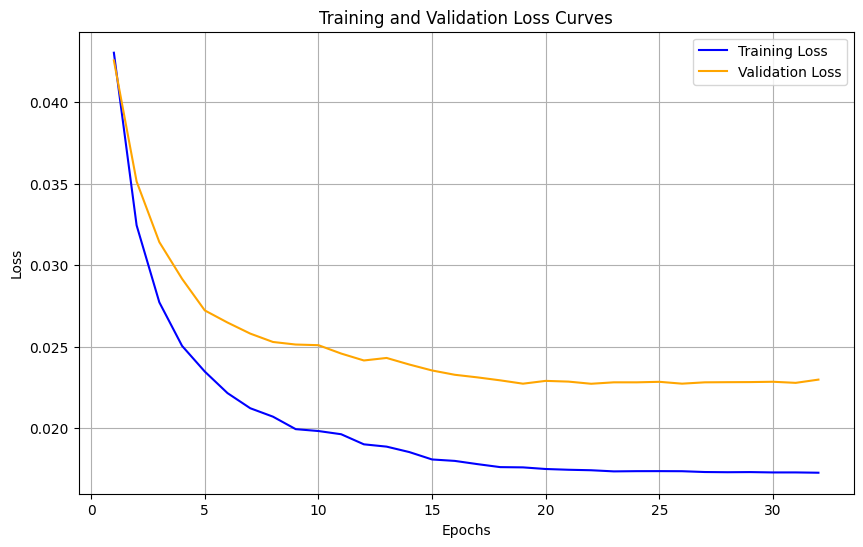

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import json
import re
from dataclasses import dataclass
import sympy

# Define a function to tokenize a formula
def tokenize_formula(formula):
    token_pattern = r"[a-zA-Z_][a-zA-Z0-9_]*|[()+\-*/]|\d+\.?\d*"
    tokens = re.findall(token_pattern, formula)
    return tokens

@dataclass
class tNetConfig:
    num_vars: int
    embedding_size: int

class tNet(nn.Module):
    def __init__(self, config: tNetConfig):
        super(tNet, self).__init__()

        self.config = config
        self.num_vars = config.num_vars
        self.n_embd = config.embedding_size

        self.activation_func = F.relu

        self.conv1 = nn.Conv1d(self.num_vars + 1, self.n_embd, 1)
        self.conv2 = nn.Conv1d(self.n_embd, 2 * self.n_embd, 1)
        self.conv3 = nn.Conv1d(2 * self.n_embd, 4 * self.n_embd, 1)

        self.fc1 = nn.Linear(4 * self.n_embd, 2 * self.n_embd)
        self.fc2 = nn.Linear(2 * self.n_embd, self.n_embd)

        self.input_batch_norm = nn.GroupNorm(1, self.num_vars + 1)

        self.bn1 = nn.GroupNorm(1, self.n_embd)
        self.bn2 = nn.GroupNorm(1, 2 * self.n_embd)
        self.bn3 = nn.GroupNorm(1, 4 * self.n_embd)
        self.bn4 = nn.GroupNorm(1, 2 * self.n_embd)
        self.bn5 = nn.GroupNorm(1, self.n_embd)

    def forward(self, x):
        """
        :param x: [batch, #features + 1, #points]
        :return: logit: [batch, embedding_size]
        """
        x = self.input_batch_norm(x)
        x = self.activation_func(self.bn1(self.conv1(x)))
        x = self.activation_func(self.bn2(self.conv2(x)))
        x = self.activation_func(self.bn3(self.conv3(x)))
        x, _ = torch.max(x, dim=2)  # global max pooling
        assert x.size(1) == 4 * self.n_embd

        x = self.activation_func(self.bn4(self.fc1(x)))
        x = self.activation_func(self.bn5(self.fc2(x)))

        return x

class TextDiffusionModel:
    def __init__(self, vocab_size, seq_len, device="cpu"):
        """
        Initialize the text diffusion model.

        Parameters:
        - vocab_size: Size of the vocabulary (number of unique tokens).
        - seq_len: Length of the token sequence.
        - device: Device to use ("cpu" or "cuda").
        """
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.device = device
        # self.noise_schedule = torch.linspace(0.01, 0.1, steps=1000).to(device)  # Noise variance per timestep
        self.noise_schedule = torch.linspace(1e-4, 2e-2, steps=1000).to(device)  # Noise variance per timestep

    def add_noise(self, tokens, t):
        """
        Add noise to a sequence of tokens based on timestep t.

        Parameters:
        - tokens: A tensor of token indices with shape (batch_size, seq_len).
        - t: A tensor of timesteps with shape (batch_size,).

        Returns:
        - noisy_tokens: The tokens with added noise.
        - noise: The noise added to the tokens.
        """
        noise_std = self.noise_schedule[t].view(-1, 1, 1)  # Shape: (batch_size, 1, 1)

        # Convert tokens to one-hot vectors
        one_hot = F.one_hot(tokens.long(), num_classes=self.vocab_size).float()
        
        # Add Gaussian noise to the one-hot vectors
        noise = torch.randn_like(one_hot) * noise_std
        noisy_one_hot = one_hot + noise

        # Compute softmax to normalize the noisy one-hot vectors
        noisy_tokens = F.softmax(noisy_one_hot, dim=-1)
        return noisy_tokens, noise

    def sample_from_noisy_tokens(self, noisy_tokens):
        """
        Sample discrete tokens from the noisy token distribution.

        Parameters:
        - noisy_tokens: A tensor of noisy token distributions with shape (batch_size, seq_len, vocab_size).

        Returns:
        - sampled_tokens: A tensor of sampled token indices with shape (batch_size, seq_len).
        """
        sampled_tokens = torch.argmax(noisy_tokens, dim=-1)
        return sampled_tokens

class ReverseProcessModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, num_vars, seq_len):
        super(ReverseProcessModel, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.num_vars = num_vars
        self.seq_len = seq_len

        # Calculate the correct input size for fc1
        input_size = embedding_size + (seq_len * vocab_size) + 1  # embeddings + noisy_tokens + timestep

        # Define layers for the reverse process model
        self.fc1 = nn.Linear(input_size, 512)  # Adjusted input size
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, seq_len * vocab_size)  # Output for all tokens in the sequence

    def forward(self, noisy_tokens, embeddings, t):
        """
        Forward pass for the reverse process model.

        :param noisy_tokens: Tensor of noisy tokens with shape [batch_size, seq_len, vocab_size].
        :param embeddings: Tensor of embeddings with shape [batch_size, embedding_size].
        :param t: Tensor of timesteps with shape [batch_size].
        :return: Predicted noise.
        """
        # Flatten noisy tokens to [batch_size, seq_len * vocab_size]
        noisy_tokens_flat = noisy_tokens.view(noisy_tokens.size(0), -1)

        # Concatenate embeddings, flattened noisy tokens, and timestep information
        timestep_embedding = torch.cat([embeddings, noisy_tokens_flat, t.unsqueeze(1).float()], dim=-1)
        
        # Pass through the fully connected layers
        x = F.relu(self.fc1(timestep_embedding))
        x = F.relu(self.fc2(x))
        predicted_noise = self.fc3(x)

        # Reshape to [batch_size, seq_len, vocab_size]
        predicted_noise = predicted_noise.view(-1, self.seq_len, self.vocab_size)
        
        return predicted_noise

# Main function
if __name__ == "__main__":

    # Define the device 
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    folder_path = "data_symbolic_regression/train"
    val_folder_path = "data_symbolic_regression/val"

    # Load and tokenize formulas from the training set; Convert the data points to a Pytorch tensor
    tokenized_formulas = []
    points_list = []

    for file_name in os.listdir(folder_path):
        if file_name.endswith(".json") and not file_name.startswith('properties'):
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, "r") as file:
                data = json.load(file)

                formula_human_readable = data.get("formula_human_readable", "")
                if formula_human_readable:
                    tokens = tokenize_formula(formula_human_readable)
                    tokenized_formulas.append(tokens)
                
                points = data.get("points")
                if points:
                    points_array = np.array([points["var_0"], points["var_1"], points["var_2"], points["target"]])
                    points_tensor = torch.tensor(points_array, dtype=torch.float32, device=device).unsqueeze(0)  # Add batch dimension
                    points_list.append(points_tensor)
                    # Need below line if points_array is transposed
                    # points_tensor = torch.tensor(points_array, dtype=torch.float32, device=device).unsqueeze(0).permute(0, 2, 1)  # Add batch dimension and transpose

    # # Create the vocabulary from the tokens
    # vocab_mapping = {token: idx for idx, token in enumerate(set(t for tokens in tokenized_formulas for t in tokens))}
    # vocab_size = len(vocab_mapping)

    # token_sequences = [[vocab_mapping[token] for token in tokens] for tokens in tokenized_formulas]

    # formula_lengths = [len(tokens) for tokens in tokenized_formulas]
    # seq_len = int(np.percentile(formula_lengths, 95))  # Use 95th percentile

    val_tokenized_formulas = []
    val_points_list = []

    # Create the vocabulary from the tokens
    for file_name in os.listdir(val_folder_path):
        if file_name.endswith(".json") and not file_name.startswith('properties'):
            file_path = os.path.join(val_folder_path, file_name)
            with open(file_path, "r") as file:
                val_data = json.load(file)

                val_formula_human_readable = val_data.get("formula_human_readable", "")
                if val_formula_human_readable:
                    val_tokens = tokenize_formula(val_formula_human_readable)
                    val_tokenized_formulas.append(val_tokens)
                
                val_points = val_data.get("points")
                if val_points:
                    val_points_array = np.array([val_points["var_0"], val_points["var_1"], val_points["var_2"], val_points["target"]])
                    val_points_tensor = torch.tensor(val_points_array, dtype=torch.float32, device=device).unsqueeze(0)  # Add batch dimension
                    val_points_list.append(val_points_tensor)

    vocab_mapping = {token: idx for idx, token in enumerate(set(t for tokens in tokenized_formulas for t in tokens))}
    vocab_size = len(vocab_mapping)

    # Define EOS and PAD token IDs
    eos_token_id = vocab_size - 1  # Assuming the last ID in the vocabulary is for EOS
    pad_token_id = vocab_size - 2  # Assuming the second-to-last ID in the vocabulary is for PAD

    # Add EOS and PAD tokens to vocab_mapping if not already present
    if eos_token_id not in vocab_mapping.values():
        vocab_mapping['<EOS>'] = eos_token_id
    if pad_token_id not in vocab_mapping.values():
        vocab_mapping['<PAD>'] = pad_token_id

    # Tokenize and map tokens to vocabulary indices
    token_sequences = [[vocab_mapping.get(token, pad_token_id) for token in tokens] for tokens in tokenized_formulas]

    # Calculate sequence length based on the 95th percentile of formula lengths
    formula_lengths = [len(tokens) for tokens in tokenized_formulas]
    seq_len = int(np.percentile(formula_lengths, 95))  # Use 95th percentile
    batch_size = 100  # Example batch size

    # Pad or truncate sequences to seq_len, adding EOS token last
    token_sequences = [
        seq[:seq_len] + [pad_token_id] * max(0, seq_len - len(seq)) + [eos_token_id] 
        if len(seq) < seq_len else seq[:seq_len] + [eos_token_id]  # Add EOS token at the end after padding
        for seq in token_sequences
    ]

    # Convert to tensor
    token_tensor = torch.tensor(token_sequences, device=device)

    # Initialize the model
    diffusion_model = TextDiffusionModel(vocab_size, seq_len, device=device)
    
    # Pad or truncate sequences to seq_len
    token_sequences = [seq[:seq_len] + [0] * max(0, seq_len - len(seq)) for seq in token_sequences]
    token_tensor = torch.tensor(token_sequences, device=device)

    val_vocab_mapping = {token: idx for idx, token in enumerate(set(t for tokens in val_tokenized_formulas for t in tokens))}
    val_vocab_size = len(val_vocab_mapping)

    # Add EOS and PAD tokens to vocab_mapping if not already present
    if eos_token_id not in val_vocab_mapping.values():
        val_vocab_mapping['<EOS>'] = eos_token_id
    if pad_token_id not in val_vocab_mapping.values():
        val_vocab_mapping['<PAD>'] = pad_token_id

    # Tokenize and map tokens to vocabulary indices
    val_token_sequences = [[val_vocab_mapping.get(token, pad_token_id) for token in tokens] for tokens in val_tokenized_formulas]

    # Calculate sequence length based on the 95th percentile of formula lengths
    val_formula_lengths = [len(tokens) for tokens in val_tokenized_formulas]
    val_seq_len = int(np.percentile(val_formula_lengths, 100))  # Use 95th percentile

    # Pad or truncate sequences to seq_len, adding EOS token last
    val_token_sequences = [
        seq[:seq_len] + [pad_token_id] * max(0, seq_len - len(seq)) + [eos_token_id] 
        if len(seq) < seq_len else seq[:seq_len] + [eos_token_id]  # Add EOS token at the end after padding
        for seq in val_token_sequences
    ]

    # Convert to tensor
    val_token_tensor = torch.tensor(val_token_sequences, device=device)

    # Initialize the model
    diffusion_model = TextDiffusionModel(vocab_size, seq_len, device=device)
    
    # Pad or truncate sequences to seq_len
    val_token_sequences = [seq[:seq_len] + [0] * max(0, seq_len - len(seq)) for seq in val_token_sequences]
    val_token_tensor = torch.tensor(val_token_sequences, device=device)

    # # Add EOS token and pad sequences
    # # Define EOS and PAD token IDs
    # eos_token_id = vocab_size - 1  # Assuming the last ID in the vocabulary is for EOS
    # pad_token_id = vocab_size - 2  # Assuming the second-to-last ID is for PAD

    # # Add EOS token and pad sequences
    # max_seq_len = max(len(seq) for seq in token_tensor)
    # padded_token_tensor = []
    # for seq in token_tensor:
    #     seq = torch.cat([seq, torch.tensor([eos_token_id])])  # Add EOS token
    #     padding = torch.tensor([pad_token_id] * (max_seq_len - len(seq)))  # Add padding
    #     seq = torch.cat([seq, padding])  # Concatenate the sequence and padding
    #     padded_token_tensor.append(seq)

    # # Convert to a tensor
    # token_tensor = torch.stack(padded_token_tensor)

    # Choose random timesteps for each sequence
    t = torch.randint(0, 1000, (len(token_tensor),), device=device)

    # Add noise to the tokens
    noisy_tokens, noise = diffusion_model.add_noise(token_tensor, t)

    # Sample from noisy tokens
    sampled_tokens = diffusion_model.sample_from_noisy_tokens(noisy_tokens)

    # Configuration for tNet
    num_vars = 3
    embedding_size = 128  # Example embedding size
    config = tNetConfig(num_vars=num_vars, embedding_size=embedding_size)

    # Instantiate the model
    tnet_model = tNet(config)

    # Input: batch_size x (num_vars + 1) x num_points
    batch_size = 1

    # Generate embeddings
    # input_tensor = torch.rand(batch_size, num_vars, 100)

    output_embeddings = []
    for pt in points_list:
        output_embedding = tnet_model(pt)
        output_embeddings.append(output_embedding)
    
    points_tensors = torch.cat(points_list, dim=0)
    
    output_embeddings_tensor = torch.cat(output_embeddings, dim=0)
    # Print the output
    print("Input shape:", points_tensors.shape)
    print("Output shape:", output_embeddings_tensor.shape)

    # Print results
    print("Original Tokens shape:", token_tensor.shape)
    print("Noisy Tokens (probabilities) shape:", noisy_tokens.shape)
    print("Sampled Tokens shape:", sampled_tokens.shape)

    # Initialize reverse model (denoiser)
    reverse_model = ReverseProcessModel(vocab_size, embedding_size, num_vars, seq_len).to(device)

    # Cross-entropy loss function
    loss_fn = nn.CrossEntropyLoss()

    # Train the reverse process model
    epochs = 1000  # Define the number of epochs for training
    batch_size = 100  # Example batch size

    # Optimizer for the reverse process model
    optimizer = torch.optim.Adam(reverse_model.parameters(), lr=1e-4)

    # Early stopping parameters
    patience = 10
    best_val_loss = float('inf')
    epochs_no_improve = 0

    import matplotlib.pyplot as plt

    # Initialize lists to store training and validation losses
    training_losses = []
    validation_losses = []

    # Training loop
    for epoch in range(epochs):
        reverse_model.train()
        total_loss = 0

        # Training Phase
        for batch_idx in range(0, len(points_list), batch_size):
            batch_points = points_list[batch_idx:batch_idx + batch_size]
            batch_token_tensor = token_tensor[batch_idx:batch_idx + batch_size]

            # Random timesteps
            t_batch = torch.randint(0, 1000, (len(batch_points),), device=device)

            # Add noise
            noisy_tokens, _ = diffusion_model.add_noise(batch_token_tensor, t_batch)

            # Get embeddings
            batch_embeddings = [tnet_model(pt) for pt in batch_points]
            embeddings_tensor = torch.cat(batch_embeddings, dim=0)

            # Predict logits
            logits = reverse_model(noisy_tokens, embeddings_tensor, t_batch)

            # Reshape logits and target tokens for CrossEntropyLoss
            logits_flat = logits.view(-1, vocab_size)
            target_tokens = batch_token_tensor.view(-1)

            # Compute loss
            loss = loss_fn(logits_flat, target_tokens)
            total_loss += loss.item()

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation Phase
        reverse_model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_batch_idx in range(0, len(val_points_list), batch_size):
                val_batch_points = val_points_list[val_batch_idx:val_batch_idx + batch_size]
                val_batch_token_tensor = val_token_tensor[val_batch_idx:val_batch_idx + batch_size]

                val_t_batch = torch.randint(0, 1000, (len(val_batch_points),), device=device)

                val_noisy_tokens, _ = diffusion_model.add_noise(val_batch_token_tensor, val_t_batch)

                val_embeddings = [tnet_model(pt) for pt in val_batch_points]
                val_embeddings_tensor = torch.cat(val_embeddings, dim=0)

                val_logits = reverse_model(val_noisy_tokens, val_embeddings_tensor, val_t_batch)
                val_logits_flat = val_logits.view(-1, vocab_size)
                val_target_tokens = val_batch_token_tensor.view(-1)

                val_loss += loss_fn(val_logits_flat, val_target_tokens).item()

        val_loss /= len(val_points_list)

        # Store losses for plotting
        training_losses.append(total_loss / len(points_list))
        validation_losses.append(val_loss)

        # Print progress
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {training_losses[-1]:.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(reverse_model.state_dict(), 'best_model.pth')  # Save the best model
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping triggered. Restoring best model...")
            reverse_model.load_state_dict(torch.load('best_model.pth'))
            break

    # Plot training and validation losses
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Loss', color='blue')
    plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import json
import re
from dataclasses import dataclass
import matplotlib.pyplot as plt

# Define a function to tokenize a formula
def tokenize_formula(formula):
    token_pattern = r"[a-zA-Z_][a-zA-Z0-9_]*|[()+\-*/]|\d+\.?\d*"
    tokens = re.findall(token_pattern, formula)
    return tokens

@dataclass
class tNetConfig:
    num_vars: int
    embedding_size: int

class tNet(nn.Module):
    def __init__(self, config: tNetConfig):
        super(tNet, self).__init__()

        self.config = config
        self.num_vars = config.num_vars
        self.n_embd = config.embedding_size

        self.activation_func = F.relu

        self.conv1 = nn.Conv1d(self.num_vars + 1, self.n_embd, 1)
        self.conv2 = nn.Conv1d(self.n_embd, 2 * self.n_embd, 1)
        self.conv3 = nn.Conv1d(2 * self.n_embd, 4 * self.n_embd, 1)

        self.fc1 = nn.Linear(4 * self.n_embd, 2 * self.n_embd)
        self.fc2 = nn.Linear(2 * self.n_embd, self.n_embd)

        self.input_batch_norm = nn.GroupNorm(1, self.num_vars + 1)

        self.bn1 = nn.GroupNorm(1, self.n_embd)
        self.bn2 = nn.GroupNorm(1, 2 * self.n_embd)
        self.bn3 = nn.GroupNorm(1, 4 * self.n_embd)
        self.bn4 = nn.GroupNorm(1, 2 * self.n_embd)
        self.bn5 = nn.GroupNorm(1, self.n_embd)

    def forward(self, x):
        """
        :param x: [batch, #features + 1, #points]
        :return: logit: [batch, embedding_size]
        """
        x = self.input_batch_norm(x)
        x = self.activation_func(self.bn1(self.conv1(x)))
        x = self.activation_func(self.bn2(self.conv2(x)))
        x = self.activation_func(self.bn3(self.conv3(x)))
        x, _ = torch.max(x, dim=2)  # global max pooling
        assert x.size(1) == 4 * self.n_embd

        x = self.activation_func(self.bn4(self.fc1(x)))
        x = self.activation_func(self.bn5(self.fc2(x)))

        return x

class TextDiffusionModel:
    def __init__(self, vocab_size, seq_len, device="cpu"):
        """
        Initialize the text diffusion model.

        Parameters:
        - vocab_size: Size of the vocabulary (number of unique tokens).
        - seq_len: Length of the token sequence.
        - device: Device to use ("cpu" or "cuda").
        """
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.device = device
        # self.noise_schedule = torch.linspace(0.01, 0.1, steps=1000).to(device)  # Noise variance per timestep
        self.noise_schedule = torch.linspace(1e-4, 2e-2, steps=1000).to(device)  # Noise variance per timestep

    def add_noise(self, tokens, t):
        """
        Add noise to a sequence of tokens based on timestep t.

        Parameters:
        - tokens: A tensor of token indices with shape (batch_size, seq_len).
        - t: A tensor of timesteps with shape (batch_size,).

        Returns:
        - noisy_tokens: The tokens with added noise.
        - noise: The noise added to the tokens.
        """
        noise_std = self.noise_schedule[t].view(-1, 1, 1)  # Shape: (batch_size, 1, 1)

        # Convert tokens to one-hot vectors
        one_hot = F.one_hot(tokens.long(), num_classes=self.vocab_size).float()
        
        # Add Gaussian noise to the one-hot vectors
        noise = torch.randn_like(one_hot) * noise_std
        noisy_one_hot = one_hot + noise

        # Compute softmax to normalize the noisy one-hot vectors
        noisy_tokens = F.softmax(noisy_one_hot, dim=-1)
        return noisy_tokens, noise

    def sample_from_noisy_tokens(self, noisy_tokens):
        """
        Sample discrete tokens from the noisy token distribution.

        Parameters:
        - noisy_tokens: A tensor of noisy token distributions with shape (batch_size, seq_len, vocab_size).

        Returns:
        - sampled_tokens: A tensor of sampled token indices with shape (batch_size, seq_len).
        """
        sampled_tokens = torch.argmax(noisy_tokens, dim=-1)
        return sampled_tokens

class ReverseProcessModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, num_vars, seq_len):
        super(ReverseProcessModel, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.num_vars = num_vars
        self.seq_len = seq_len

        # Calculate the correct input size for fc1
        input_size = embedding_size + (seq_len*vocab_size) + 1 
        #input_size = embedding_size + ((seq_len - 1)*(vocab_size-2)) + 1  # embeddings + noisy_tokens + timestep

        # Define layers for the reverse process model
        self.fc1 = nn.Linear(input_size, 512)  # Adjusted input size
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, seq_len * vocab_size)  # Output for all tokens in the sequence

    def forward(self, noisy_tokens, embeddings, t):
        """
        Forward pass for the reverse process model.

        :param noisy_tokens: Tensor of noisy tokens with shape [batch_size, seq_len, vocab_size].
        :param embeddings: Tensor of embeddings with shape [batch_size, embedding_size].
        :param t: Tensor of timesteps with shape [batch_size].
        :return: Predicted noise.
        """
        # Flatten noisy tokens to [batch_size, seq_len * vocab_size]
        noisy_tokens_flat = noisy_tokens.view(noisy_tokens.size(0), -1)

        # Concatenate embeddings, flattened noisy tokens, and timestep information
        timestep_embedding = torch.cat([embeddings, noisy_tokens_flat, t.unsqueeze(1).float()], dim=-1)
        
        # Pass through the fully connected layers
        x = F.relu(self.fc1(timestep_embedding))
        x = F.relu(self.fc2(x))
        predicted_noise = self.fc3(x)

        # Reshape to [batch_size, seq_len, vocab_size]
        predicted_noise = predicted_noise.view(-1, self.seq_len, self.vocab_size)
        
        return predicted_noise

# Main function
if __name__ == "__main__":

    # Define the device 
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    folder_path = "data_symbolic_regression/train"
    val_folder_path = "data_symbolic_regression/val"

    # Load and tokenize formulas from the training set; Convert the data points to a Pytorch tensor
    tokenized_formulas = []
    all_tokenized_formulas = []
    points_list = []

    for file_name in os.listdir(folder_path):
        if file_name.endswith(".json") and not file_name.startswith('properties'):
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, "r") as file:
                data = json.load(file)

                formula_human_readable = data.get("formula_human_readable", "")
                if formula_human_readable:
                    tokens = tokenize_formula(formula_human_readable)
                    tokenized_formulas.append(tokens)
                    all_tokenized_formulas.append(tokens)
                
                points = data.get("points")
                if points:
                    points_array = np.array([points["var_0"], points["var_1"], points["var_2"], points["target"]])
                    points_tensor = torch.tensor(points_array, dtype=torch.float32, device=device).unsqueeze(0)  # Add batch dimension
                    points_list.append(points_tensor)
                    # Need below line if points_array is transposed
                    # points_tensor = torch.tensor(points_array, dtype=torch.float32, device=device).unsqueeze(0).permute(0, 2, 1)  # Add batch dimension and transpose

    val_tokenized_formulas = []
    val_points_list = []

    # Create the vocabulary from the tokens
    for file_name in os.listdir(val_folder_path):
        if file_name.endswith(".json") and not file_name.startswith('properties'):
            file_path = os.path.join(val_folder_path, file_name)
            with open(file_path, "r") as file:
                val_data = json.load(file)

                val_formula_human_readable = val_data.get("formula_human_readable", "")
                if val_formula_human_readable:
                    val_tokens = tokenize_formula(val_formula_human_readable)
                    val_tokenized_formulas.append(val_tokens)
                    all_tokenized_formulas.append(val_tokens)
                
                val_points = val_data.get("points")
                if val_points:
                    val_points_array = np.array([val_points["var_0"], val_points["var_1"], val_points["var_2"], val_points["target"]])
                    val_points_tensor = torch.tensor(val_points_array, dtype=torch.float32, device=device).unsqueeze(0)  # Add batch dimension
                    val_points_list.append(val_points_tensor)

    vocab_mapping = {token: idx for idx, token in enumerate(set(t for tokens in all_tokenized_formulas for t in tokens))}
    vocab_size = len(vocab_mapping)

    # Define EOS and PAD token IDs
    eos_token_id = vocab_size  # Assuming the last ID in the vocabulary is for EOS
    pad_token_id = vocab_size + 1 # Assuming the second-to-last ID in the vocabulary is for PAD

    # Add EOS and PAD tokens to vocab_mapping if not already present
    if eos_token_id not in vocab_mapping.values():
        vocab_mapping['<EOS>'] = eos_token_id
    if pad_token_id not in vocab_mapping.values():
        vocab_mapping['<PAD>'] = pad_token_id
    
    # Tokenize and map tokens to vocabulary indices
    token_sequences = [[vocab_mapping.get(token, pad_token_id) for token in tokens] for tokens in tokenized_formulas]

    # Calculate sequence length based on the 95th percentile of formula lengths
    formula_lengths = [len(tokens) for tokens in tokenized_formulas]
    seq_len = int(np.percentile(formula_lengths, 95)) + 1  # Use 95th percentile
    batch_size = 100  # Example batch size

    # Pad or truncate sequences to seq_len, adding EOS token last
    token_sequences = [
        seq[:seq_len] + [pad_token_id]*max(0, seq_len - len(seq)) + [eos_token_id] 
        if len(seq) < seq_len else seq[:seq_len] + [eos_token_id]  # Add EOS token at the end after padding
        for seq in token_sequences
    ]

    # Convert to tensor
    token_tensor = torch.tensor(token_sequences, device=device)

    # Initialize the model
    diffusion_model = TextDiffusionModel(vocab_size, seq_len, device=device)

    # Tokenize and map tokens to vocabulary indices
    val_token_sequences = [[vocab_mapping.get(token, pad_token_id) for token in tokens] for tokens in val_tokenized_formulas]
    
    val_token_sequences = [
        seq[:seq_len] + [eos_token_id] + [pad_token_id]*max(0, seq_len - len(seq))
        if len(seq) < seq_len else seq[:seq_len] + [eos_token_id]  # Add EOS token at the end after padding
        for seq in val_token_sequences
    ]
    
    # Convert to tensor
    val_token_tensor = torch.tensor(val_token_sequences, device=device)

    # Initialize the model
    diffusion_model = TextDiffusionModel(vocab_size, seq_len, device=device)
    
    # Pad or truncate sequences to seq_len
    val_token_sequences = [seq[:seq_len] + [0] * max(0, seq_len - len(seq)) for seq in val_token_sequences]
    val_token_tensor = torch.tensor(val_token_sequences, device=device)

    t = torch.randint(0, 1000, (len(token_tensor),), device=device)

    # Add noise to the tokens
    noisy_tokens, noise = diffusion_model.add_noise(token_tensor, t)

    # Sample from noisy tokens
    sampled_tokens = diffusion_model.sample_from_noisy_tokens(noisy_tokens)

    # Configuration for tNet
    num_vars = 3
    embedding_size = 128  # Example embedding size
    config = tNetConfig(num_vars=num_vars, embedding_size=embedding_size)

    # Instantiate the model
    tnet_model = tNet(config)

    # Input: batch_size x (num_vars + 1) x num_points
    batch_size = 1

    # Generate embeddings
    # input_tensor = torch.rand(batch_size, num_vars, 100)

    output_embeddings = []
    for pt in points_list:
        output_embedding = tnet_model(pt)
        output_embeddings.append(output_embedding)
    
    points_tensors = torch.cat(points_list, dim=0)
    
    output_embeddings_tensor = torch.cat(output_embeddings, dim=0)
    # Print the output
    print("Input shape:", points_tensors.shape)
    print("Output shape:", output_embeddings_tensor.shape)

    # Print results
    print("Original Tokens shape:", token_tensor.shape)
    print("Noisy Tokens (probabilities) shape:", noisy_tokens.shape)
    print("Sampled Tokens shape:", sampled_tokens.shape)

    # Initialize reverse model (denoiser)
    reverse_model = ReverseProcessModel(vocab_size, embedding_size, num_vars, seq_len).to(device)

    # Cross-entropy loss function
    loss_fn = nn.CrossEntropyLoss()

    # Train the reverse process model
    epochs = 1000  # Define the number of epochs for training
    batch_size = 100  # Example batch size

    # Optimizer for the reverse process model
    optimizer = torch.optim.Adam(reverse_model.parameters(), lr=1e-4)

    # Early stopping parameters
    patience = 10
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # Initialize lists to store training and validation losses
    training_losses = []
    validation_losses = []

    # Training loop
    for epoch in range(epochs):
        reverse_model.train()
        total_loss = 0

        # Training Phase
        for batch_idx in range(0, len(points_list), batch_size):
            batch_points = points_list[batch_idx:batch_idx + batch_size]
            batch_token_tensor = token_tensor[batch_idx:batch_idx + batch_size]

            # Random timesteps
            t_batch = torch.randint(0, 1000, (len(batch_points),), device=device)

            # Add noise
            noisy_tokens, _ = diffusion_model.add_noise(batch_token_tensor, t_batch)

            # Get embeddings
            batch_embeddings = [tnet_model(pt) for pt in batch_points]
            embeddings_tensor = torch.cat(batch_embeddings, dim=0)

            # Predict logits
            logits = reverse_model(noisy_tokens, embeddings_tensor, t_batch)

            # Reshape logits and target tokens for CrossEntropyLoss
            logits_flat = logits.view(-1, vocab_size)
            target_tokens = batch_token_tensor.view(-1)

            # Compute loss
            loss = loss_fn(logits_flat, target_tokens)
            total_loss += loss.item()

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation Phase
        reverse_model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_batch_idx in range(0, len(val_points_list), batch_size):
                val_batch_points = val_points_list[val_batch_idx:val_batch_idx + batch_size]
                val_batch_token_tensor = val_token_tensor[val_batch_idx:val_batch_idx + batch_size]

                val_t_batch = torch.randint(0, 1000, (len(val_batch_points),), device=device)

                val_noisy_tokens, _ = diffusion_model.add_noise(val_batch_token_tensor, val_t_batch)

                val_embeddings = [tnet_model(pt) for pt in val_batch_points]
                val_embeddings_tensor = torch.cat(val_embeddings, dim=0)

                val_logits = reverse_model(val_noisy_tokens, val_embeddings_tensor, val_t_batch)
                val_logits_flat = val_logits.view(-1, vocab_size)
                val_target_tokens = val_batch_token_tensor.view(-1)

                val_loss += loss_fn(val_logits_flat, val_target_tokens).item()

        val_loss /= len(val_points_list)

        # Store losses for plotting
        training_losses.append(total_loss / len(points_list))
        validation_losses.append(val_loss)

        # Print progress
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {training_losses[-1]:.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(reverse_model.state_dict(), 'best_model.pth')  # Save the best model
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping triggered. Restoring best model...")
            reverse_model.load_state_dict(torch.load('best_model.pth'))
            break

    # Plot training and validation losses
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Loss', color='blue')
    plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

RuntimeError: Class values must be smaller than num_classes.

In [17]:
import torch
import os
import json
import numpy as np
from sklearn.metrics import accuracy_score

def evaluate_diffusion_model(test_folder, diffusion_model, reverse_model, tnet_model, vocab_mapping, seq_len, device):
    """
    Evaluate the diffusion model on the test set.

    Parameters:
    - test_folder: Path to the folder containing the test JSON files.
    - diffusion_model: Instance of the TextDiffusionModel.
    - reverse_model: Instance of the ReverseProcessModel.
    - tnet_model: Instance of the tNet model for generating embeddings.
    - vocab_mapping: Dictionary mapping tokens to indices.
    - seq_len: Length of the token sequence.
    - device: Device to use ("cpu" or "cuda").

    Returns:
    - results: List of tuples (actual_formula, reconstructed_formula).
    """
    reverse_vocab_mapping = {idx: token for token, idx in vocab_mapping.items()}

    results = []

    for file_name in os.listdir(test_folder):
        if file_name.endswith(".json") and not file_name.startswith('properties'):
            file_path = os.path.join(test_folder, file_name)

            with open(file_path, "r") as file:
                data = json.load(file)

                formula_human_readable = data.get("formula_human_readable", "")
                tokens = tokenize_formula(formula_human_readable)

                # Convert tokens to indices
                token_indices = [vocab_mapping.get(token, 0) for token in tokens]

                # Pad or truncate to seq_len
                token_indices = token_indices[:seq_len] + [0] * max(0, seq_len - len(token_indices))
                token_tensor = torch.tensor(token_indices, device=device).unsqueeze(0)  # Add batch dimension

                points = data.get("points")
                if points:
                    points_array = np.array([points["var_0"], points["var_1"], points["var_2"], points["target"]])
                    points_tensor = torch.tensor(points_array, dtype=torch.float32, device=device).unsqueeze(0)

                    # Generate embeddings using tNet model
                    embedding = tnet_model(points_tensor)

                    # Choose random timestep
                    t = torch.randint(0, 1000, (1,), device=device)

                    # Add noise to the tokens
                    noisy_tokens, _ = diffusion_model.add_noise(token_tensor, t)

                    # Use reverse model to reconstruct the clean tokens
                    reconstructed_noise = reverse_model(noisy_tokens, embedding, t)
                    # print(f"Reconstructed Noise Shape: {reconstructed_noise.shape}")
                    # Convert reconstructed noise to token indices
                    # reconstructed_tokens = torch.argmax(reconstructed_noise, dim=-1).squeeze(0)

                    # Ensure reconstructed_tokens is a list
                    reconstructed_tokens = torch.argmax(reconstructed_noise, dim=-1)
                    # print(reconstructed_tokens)
                    if reconstructed_tokens.dim() == 2:  # Case: (batch_size, seq_len)
                        reconstructed_tokens = reconstructed_tokens.squeeze(0)  # Remove batch dimension
                    elif reconstructed_tokens.dim() == 1:  # Case: (seq_len,)
                        pass  # Already correct
                    else:
                        raise ValueError(f"Unexpected shape for reconstructed_tokens: {reconstructed_tokens.shape}")

                    # print(reconstructed_tokens)
                    # Map token indices back to tokens
                    reconstructed_formula = " ".join(
                        reverse_vocab_mapping[idx] if idx in reverse_vocab_mapping else "<UNK>" for idx in reconstructed_tokens.tolist()
                    )
                    
                    actual_formula = " ".join(tokens)

                    results.append((actual_formula, reconstructed_formula))

    return results

In [10]:
# Define the device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

folder_path_test = "data_symbolic_regression/test"

# Load and tokenize formulas from the training set; Convert the data points to a Pytorch tensor
tokenized_formulas_test = []
points_list_test = []

for file_name in os.listdir(folder_path_test):
    if file_name.endswith(".json") and not file_name.startswith('properties'):
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, "r") as file:
            data = json.load(file)

            formula_human_readable_test = data.get("formula_human_readable", "")
            if formula_human_readable_test:
                tokens_test = tokenize_formula(formula_human_readable_test)
                tokenized_formulas_test.append(tokens_test)
                
            points_test = data.get("points")
            if points_test:
                points_array_test = np.array([points_test["var_0"], points_test["var_1"], points_test["var_2"], points_test["target"]])
                points_tensor_test = torch.tensor(points_array_test, dtype=torch.float32, device=device).unsqueeze(0)  # Add batch dimension
                points_list_test.append(points_tensor_test)
                # Need below line if points_array is transposed
                # points_tensor = torch.tensor(points_array, dtype=torch.float32, device=device).unsqueeze(0).permute(0, 2, 1)  # Add batch dimension and transpose

# Create the vocabulary from the tokens
# vocab_mapping_test = {token: idx for idx, token in enumerate(set(t for tokens in tokenized_formulas_test for t in tokens))}
# vocab_size_test = len(vocab_mapping_test)

# token_sequences_test = [[vocab_mapping_test[token] for token in tokens] for tokens in tokenized_formulas_test]

# formula_lengths_test = [len(tokens) for tokens in tokenized_formulas_test]
# seq_len_test = int(np.percentile(formula_lengths_test, 95))  # Use 95th percentile

# # Initialize the model
# diffusion_model_test = TextDiffusionModel(vocab_size_test, seq_len_test, device=device)
    
# # Pad or truncate sequences to seq_len
# token_sequences_test = [seq[:seq_len] + [0] * max(0, seq_len - len(seq)) for seq in token_sequences_test]
# token_tensor_test = torch.tensor(token_sequences_test, device=device)

# # Choose random timesteps for each sequence
# t = torch.randint(0, 1000, (len(token_tensor_test),), device=device)

# # Configuration for tNet
# num_vars_test = 3
# embedding_size_test = 32  # Example embedding size
# config_test = tNetConfig(num_vars=num_vars_test, embedding_size=embedding_size_test)

# # Instantiate the model
# tnet_model_test = tNet(config_test)

# reverse_model = ReverseProcessModel(vocab_size_test, embedding_size_test, num_vars_test, seq_len_test).to(device)

# Evaluate the model
results = evaluate_diffusion_model(folder_path_test, diffusion_model, reverse_model, tnet_model, vocab_mapping, seq_len, device)

# Display example results
example_idx = 2  # Index of the example to display

if results:
    actual, reconstructed = results[example_idx]
    print(f"Actual Formula: {actual}")
    print(f"Reconstructed Formula: {reconstructed}")

# Calculate accuracy or similarity score (optional)
# accuracies = [accuracy_score(list(actual), list(reconstructed)) for actual, reconstructed in results]
# print(f"Average Reconstruction Accuracy: {np.mean(accuracies):.2f}")

Actual Formula: ( ( exp ( var_1 ) * var_2 ) + log ( ( var_2 * var_0 ) ) )
Reconstructed Formula: ( ( ( ( ( ) ) ) ) * ) ( ) ( ( ) ) ) neg neg neg neg neg neg
